# <font color = 'green'> Text cleaning and preprocessing.
Since *cleaned_objective_strategy* has been cleaned in section 1, we will focus on lemmatization and tokenization in this section. </font>

## <font color = 'green'> Lemmatization. </font>


In [2]:
import os
import pickle

path = r'C:\Users\zhaoz\Desktop\bigdata\finalproject\data'

In [16]:
# load data
with open(path + r'\strategy_descriptions_esg_related.pkl', 'rb') as f:
    strategy_descriptions_esg_related = pickle.load(f)

In [28]:
strategy_descriptions_esg_related.head()

,adsh,cik_expanded,name,period_end_date,objective,strategy,cleaned_objective_strategy,esg_labels,__index_level_0__
0,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,The fund seeks long-term capital growth.,The fund will generally invest in larger-sized...,fund seeks long term capital growth fund gener...,Corporate Governance,32
1,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,The fund seeks long-term capital growth.,The portfolio managers look for stocks of comp...,fund seeks long term capital growth portfolio ...,Corporate Governance,35
2,0000100334-17-000063,100334,"AMERICAN CENTURY MUTUAL FUNDS, INC.",20170301,The fund seeks long-term capital growth.,"Under normal market conditions, the fund will ...",fund seeks long term capital growth normal mar...,Corporate Governance,36
3,0001162044-17-000431,1003839,MATTHEW 25 FUND,20170501,"Matthew 25 Fund (""""the Fund"""") seeks long-term...",The Fund blends Growth and Value Investing in ...,fund seeks long term capital appreciation fund...,Corporate Governance,53
4,0000932471-17-003517,1004655,VANGUARD WHITEHALL FUNDS,20170223,The Fund seeks to provide long-term capital ap...,The Fund invests mainly in the stocks of mid-s...,fund seeks provide long term capital appreciat...,Corporate Governance,59


In [2]:
#%pip install Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#%pip install spacy
import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

def run_NLP(content):

    def sent_to_words(text):
        yield(gensim.utils.simple_preprocess(text))

    # Define functions for bigrams, trigrams and lemmatization

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(' '.join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words)

    # Do lemmatization keeping only noun, adj, vb, adv
    lemma = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
    
    return lemma

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
from tqdm import tqdm, trange

lemmas = []

for s in strategy_descriptions_esg_related['cleaned_objective_strategy']:
    lemma = run_NLP(s)[0]
    lemmas.append(lemma)

In [19]:
#save lemmas as pickle file
with open(path + r'\lemmas.pickle', 'wb') as f:
    pickle.dump(lemmas, f)

## <font color = 'green'> Drop customize stopwords. 
Although we have removed common english stopwords from raw text in section 1, there are certain words out of *nltk stopwords* we'd like to drop before analysis. </font>

In [6]:
import os
import pickle

#read lemmas from pickle file
with open(path + r'\lemmas.pickle', 'rb') as f:
    lemmas = pickle.load(f)

DescribeResult(nobs=2203, minmax=(1, 12728), mean=76.61779391738538, variance=211215.07092755605, skewness=16.303046746231665, kurtosis=346.6311728357838)


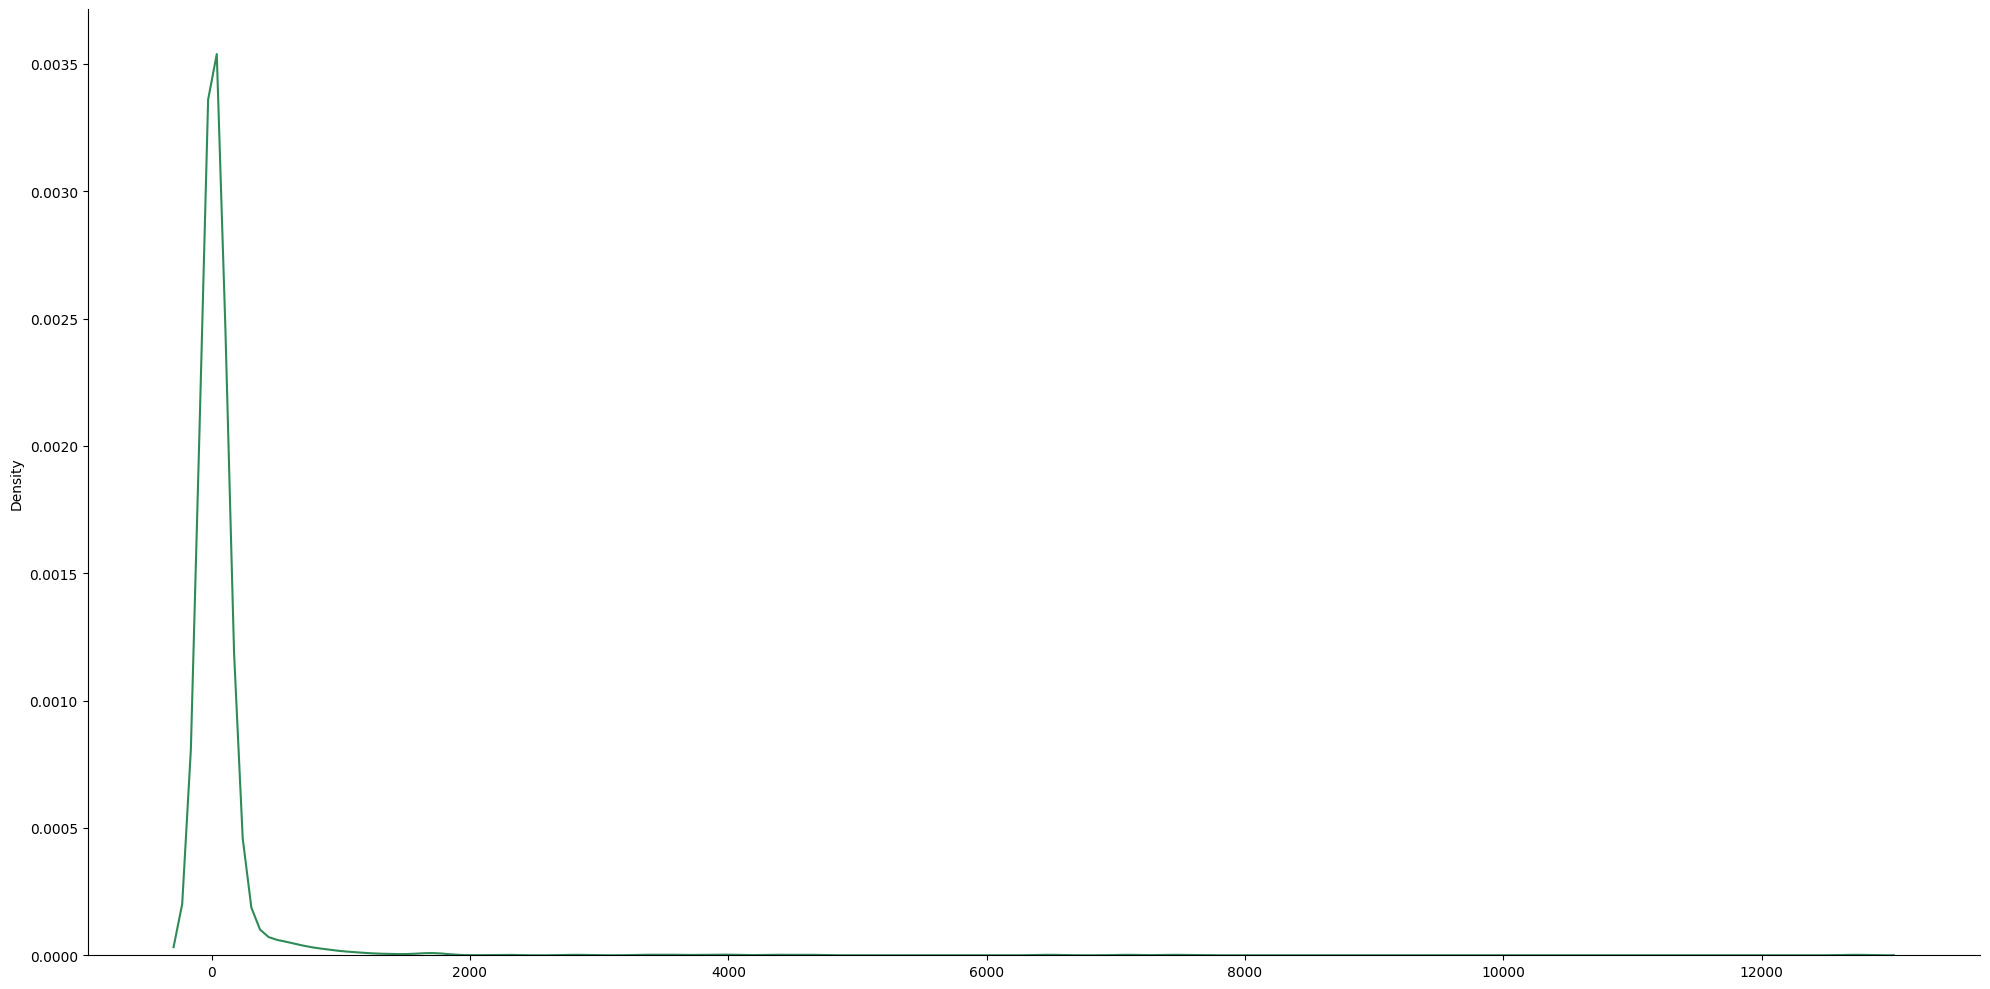

In [7]:
# aggregate all text into one large string to run counter on term frequency
large_string = ' '.join(word for l in lemmas for word in l)

#count the apparence frequency of all the noun 
from collections import Counter        

words_freq = Counter(large_string.split())

#%pip install scipy
from scipy import stats
import numpy as np

freqs = np.array(list(words_freq.values()))

import seaborn as sns
sns.displot(freqs, kind="kde", color='seagreen', height=10, aspect=2)

print(stats.describe(freqs, axis=0, ddof=1, bias=True, nan_policy='propagate'))

We can see that corpus distribution is extremely left-skewed. We will drop words with too many or too few occurance from the whole corpus since these words could be not conducive for us to featuring paragraphs.

In [8]:
full_words = list(words_freq.keys())

#quantiles
min_count = np.quantile(freqs, 0.1)
max_count = np.quantile(freqs, 0.9)

def remove_key(d):
    for key in list(d.keys()):
        if (key.isalpha() == False) or (len(key)<2):
            d.pop(key)
        if (d[key] > max_count) or (d[key] < min_count):
            del d[key]

words_freq_copy = words_freq.copy()

remove_key(words_freq_copy)

drop_words = list(set(full_words)-set(list(words_freq_copy.keys())))

len(drop_words)

220

In [9]:
#save drop_words as pickle file
with open(path + r'\drop_words.pickle', 'wb') as f2:
    pickle.dump(drop_words, f2)

## <font color = 'green'> Corpus wide term frequencies </font>

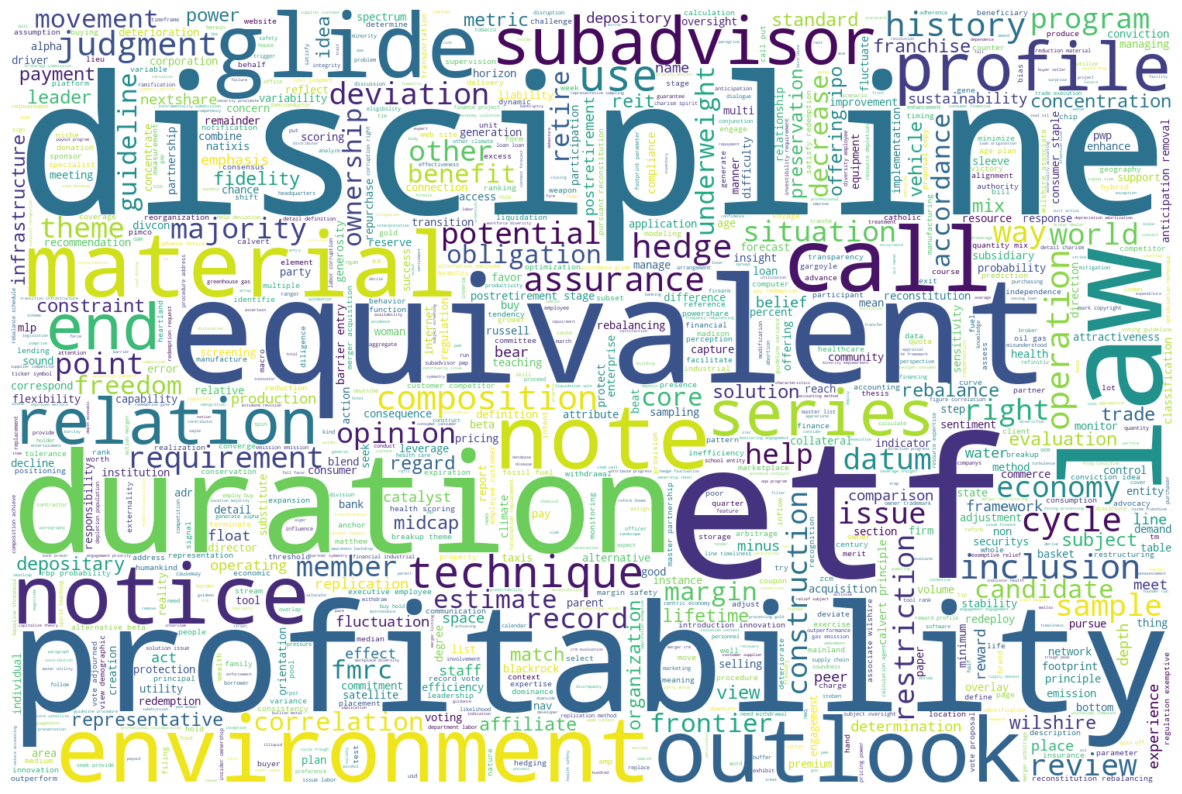

In [10]:
#%pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    stopwords=drop_words,
    background_color="white",
    max_words=1000, 
    width=1500, 
    height=1000,
    contour_width=3, 
    contour_color='seagreen'
)

# display our wordcloud across all records
plt.figure(figsize=(15,15))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

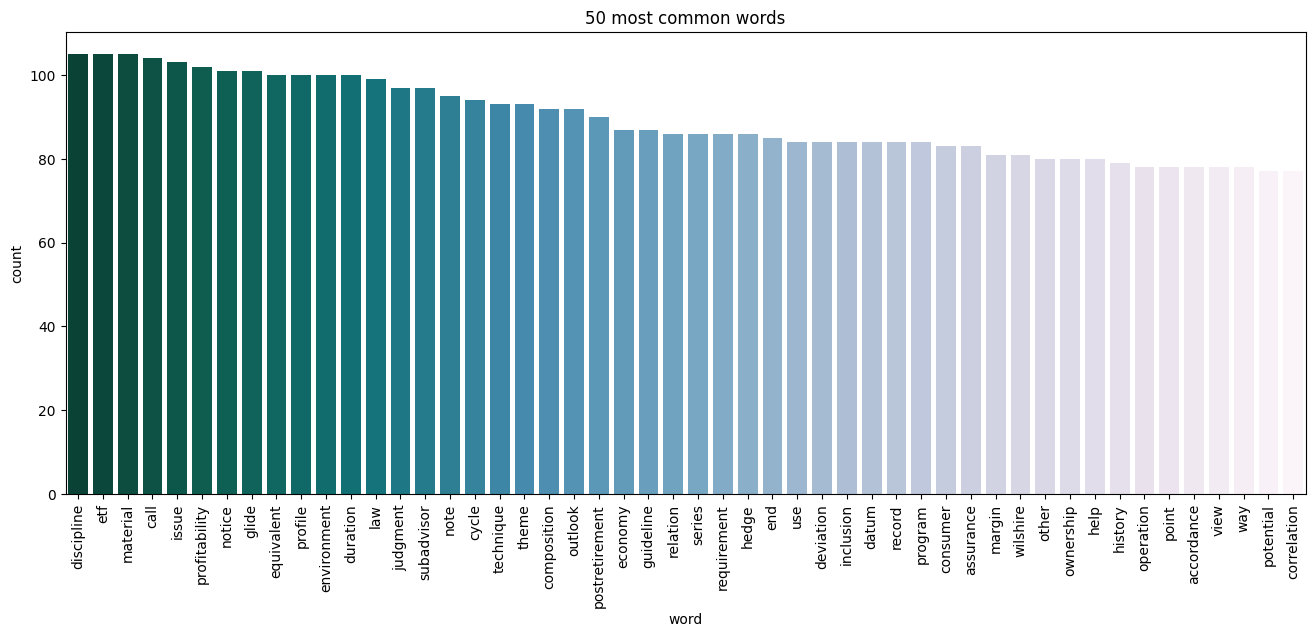

In [11]:
#%pip install seaborn
import seaborn as sns

#remove drop words from large string and count the word frequency again
large_string = ' '.join(word for l in lemmas for word in l if word not in drop_words)

words_freq = Counter(large_string.split())

most_common_words = words_freq.most_common(50)
most_common_words = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Plot top 50 ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='50 most common words')
sns.barplot(x=most_common_words['word'], y=most_common_words['count'], palette='PuBuGn_r')
plt.xticks(rotation=90)
plt.show()

# <font color = 'green'> Topic Modeling</font>

## <font color = 'green'> TFIDF - Bigram Analysis </font>

In [12]:
#%pip install scikit-learn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

string_lemmas = []
for l in lemmas:
    string_lemma = ' '.join(word for word in l)
    string_lemmas.append(string_lemma)
 
# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words = drop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(string_lemmas)

In [13]:
with open(path + r'\b_tfidf.pickle', 'wb') as f3:
    pickle.dump(bigram_tf_idf, f3)

## <font color = 'green'> Principal Component Analysis (PCA) </font>

In [14]:
import os
import pickle

path = r'C:\Users\zhaoz\Desktop\bigdata\finalproject\data'

#read bigram_tf_idf from pickle file
with open(path + r'\b_tfidf.pickle', 'rb') as f3:
    bigram_tf_idf = pickle.load(f3)

In [17]:
import pandas as pd

idf = pd.DataFrame(bigram_tf_idf.todense(), columns = bigram_tf_idf_vectorizer.get_feature_names_out())

idf['adsh'] = strategy_descriptions_esg_related['adsh']
idf.head()

,access,accordance,accordance effect,accounting,acquisition,act,act regulation,action,address,adherence,...,website,well,whole,whole substitute,wilshire,wilshire associate,withdrawal,withdrawal relation,world,adsh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000100334-17-000063
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000100334-17-000063
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000100334-17-000063
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0001162044-17-000431
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0000932471-17-003517


In [18]:
#save idf as pickle file
with open(path + r'\idf.pickle', 'wb') as f4:
    pickle.dump(idf, f4)

#save idf as parquet file
idf.to_parquet(path + r'\idf.parquet')

100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


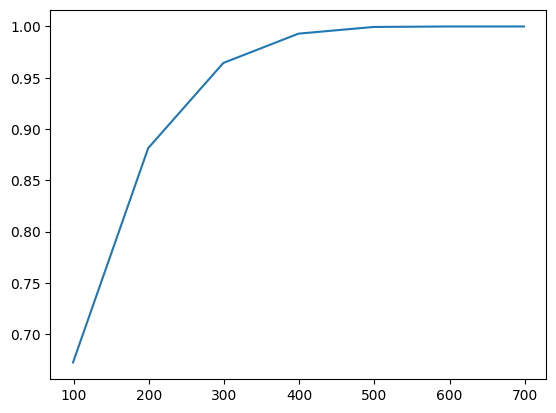

[0.67224959262285,
 0.8812788391416646,
 0.9644147626182186,
 0.9930048683730052,
 0.9995394670729347,
 0.9999999999999999,
 1.0]

In [19]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA.set_params
from tqdm import tqdm

score_all=[]

no_of_components = range(99, 700, 100)

df = idf.iloc[:,idf.columns!= 'adsh']

for i in tqdm(no_of_components):
    pca = PCA(n_components=i)
    reduced_data = pca.fit_transform(df) 
    score= pca.explained_variance_ratio_
    score_all.append(score.sum())

plt.plot(no_of_components,score_all)
plt.show()
score_all

In [20]:
reduced_bigram_tf_idf = PCA(n_components=399).fit_transform(bigram_tf_idf.toarray())

c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\zhaoz\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


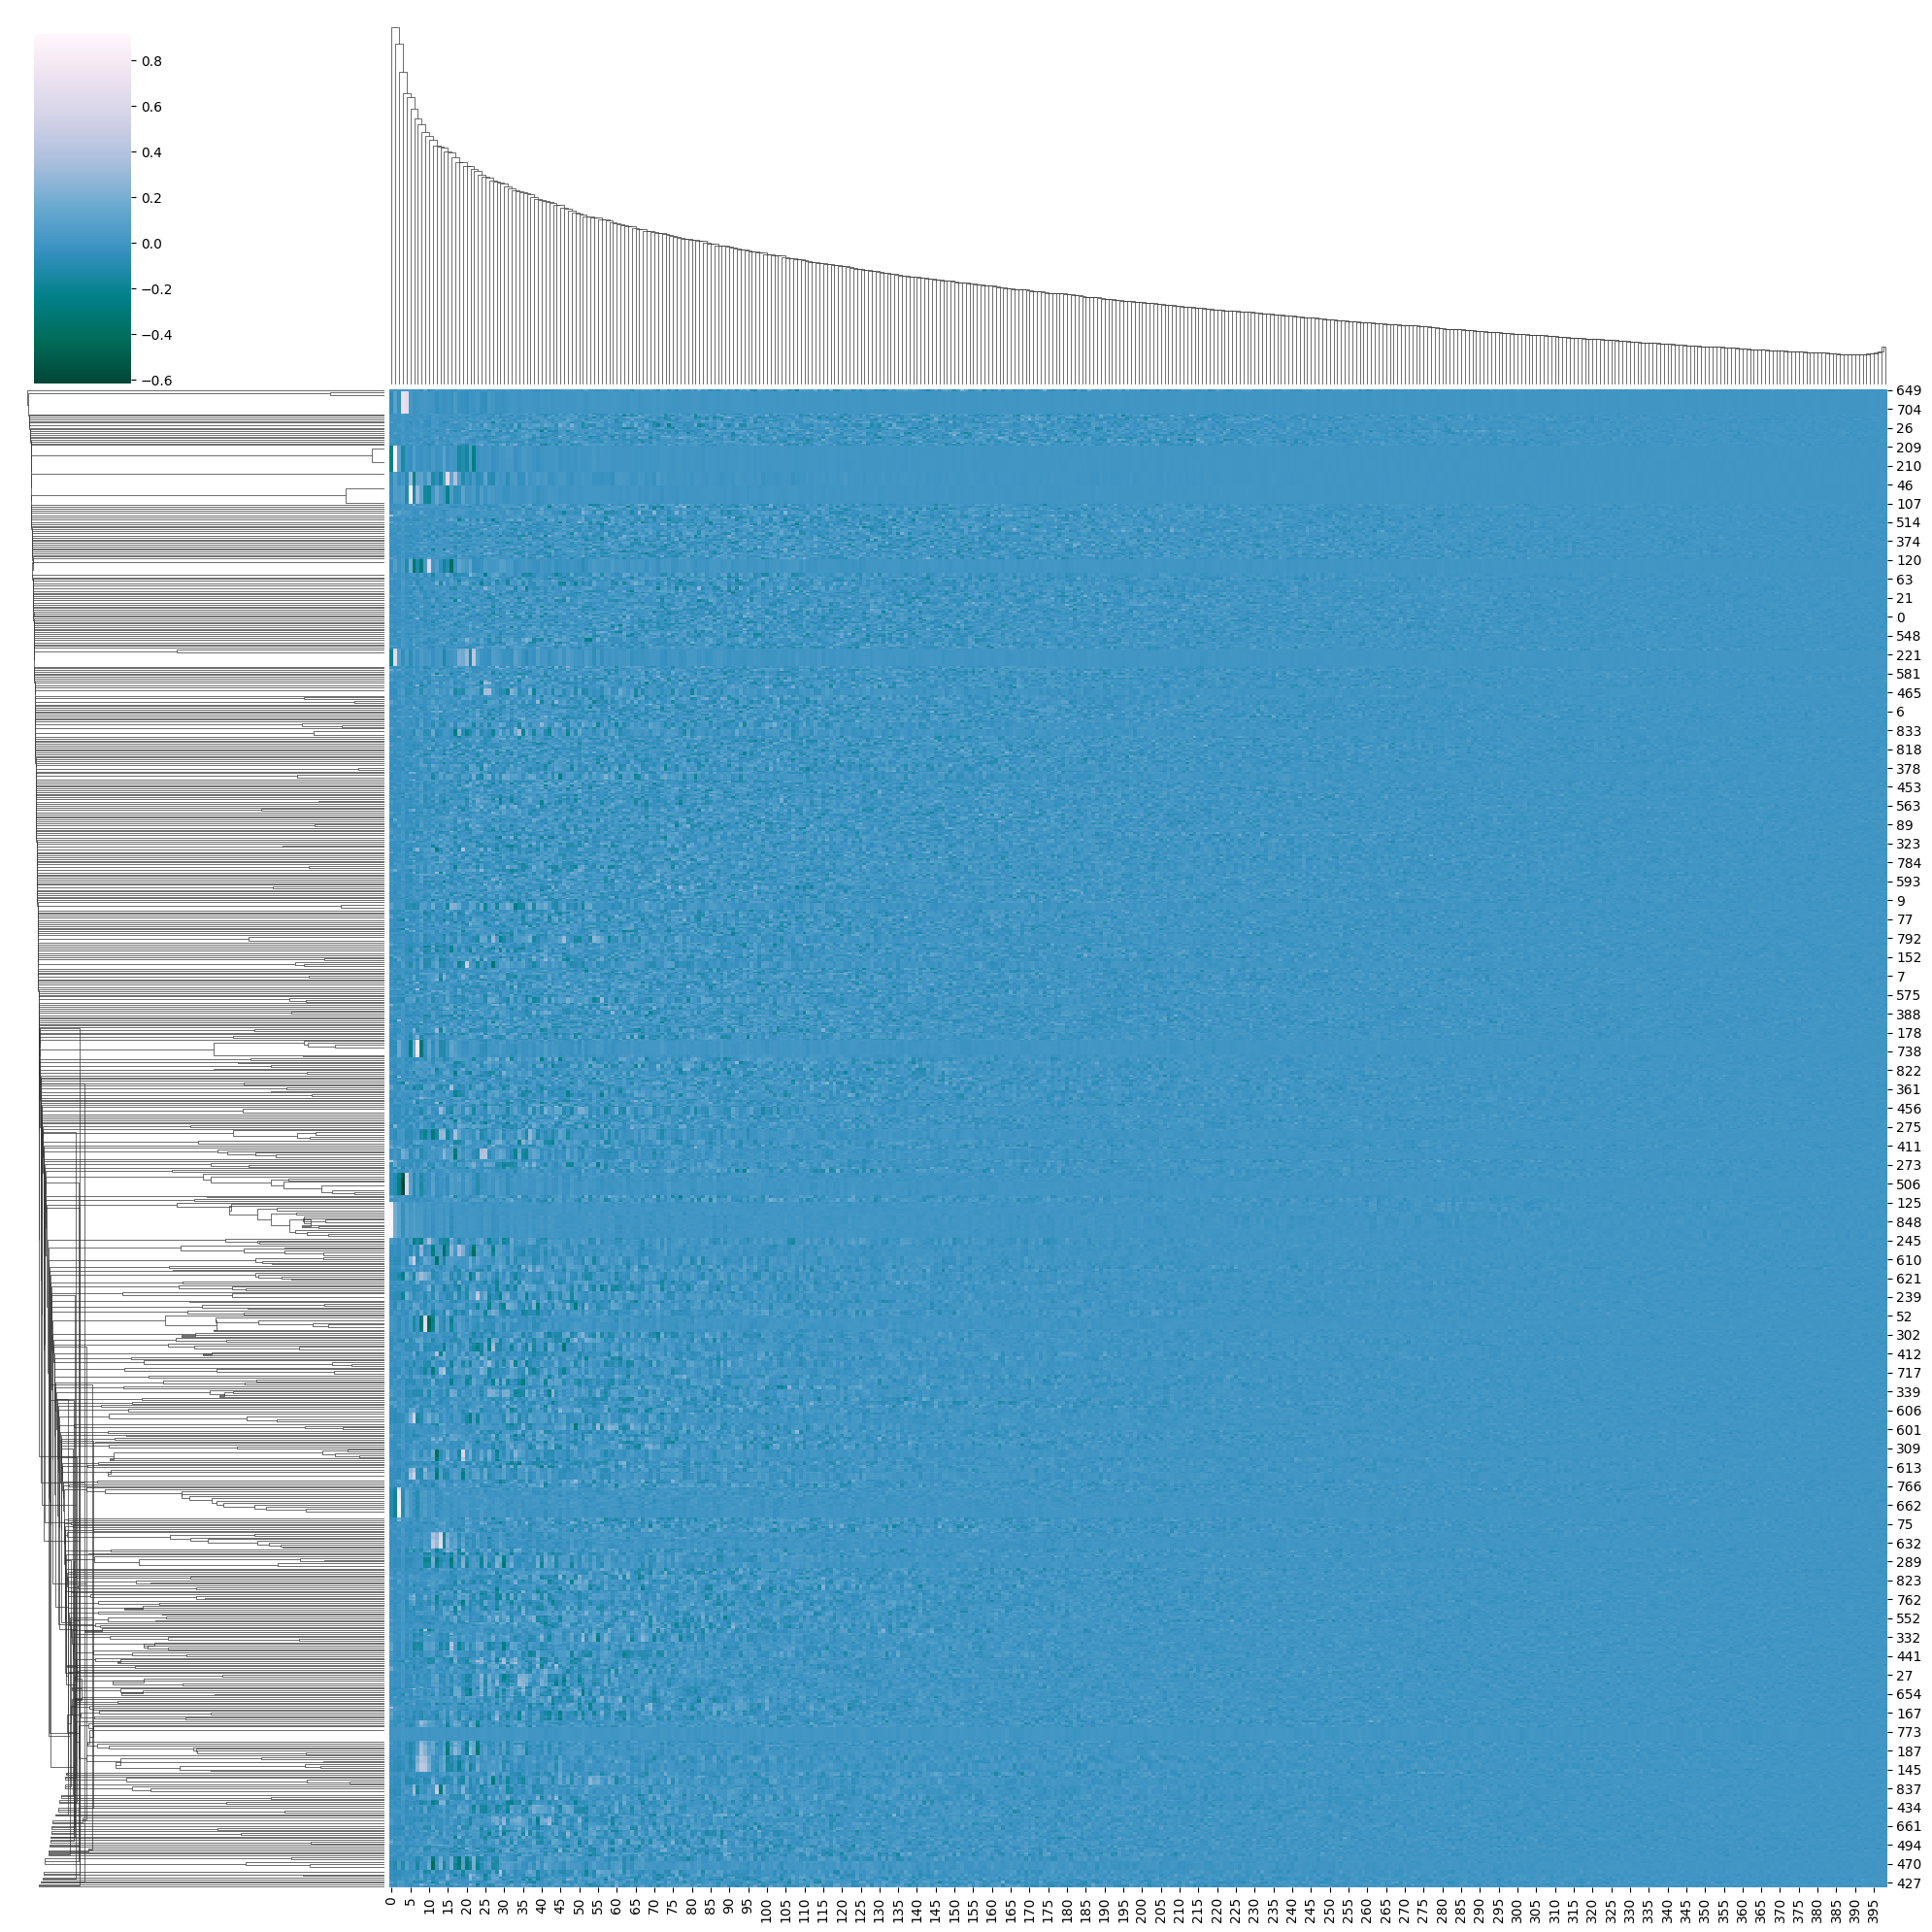

In [21]:
sns.clustermap(reduced_bigram_tf_idf, cmap='PuBuGn_r', figsize=(20, 20), method='centroid', metric='euclidean')

## <font color = 'green'> Latent Dirichlet Allocation (LDA) </font>
We will use LDA model to get topics and features.</br>

*Ref:* https://radimrehurek.com/gensim/models/ldamodel.html

In [22]:
import os
import pickle
import pandas as pd
import numpy as np

path = r'C:\Users\zhaoz\Desktop\bigdata\finalproject\data'

In [23]:
lemmas = pickle.load(open(path + r'\lemmas.pickle', 'rb'))
drop_words = pickle.load(open(path + r'\drop_words.pickle', 'rb'))

In [24]:
#remove drop words from lemma
clean_lemmas = []
for l in lemmas:
    clean_lemma = [word for word in l if word not in drop_words]
    clean_lemmas.append(clean_lemma)

In [25]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Create Dictionary
id2word = corpora.Dictionary(lemmas)

# Term Document Frequency
corpus = [id2word.doc2bow(lemma) for lemma in lemmas]

In [26]:
from tqdm import tqdm, trange

results = []
optimal_score = 0
optimal_model = None

for num_of_topics in trange(1,21,1):
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics = num_of_topics,
                                            random_state=10,
                                            update_every=1,
                                            chunksize=10,
                                            alpha='auto',
                                            eta='auto',
                                            per_word_topics=True) 
    
    result = {}
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmas, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)


results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True)
results

100%|██████████| 20/20 [05:34<00:00, 16.71s/it]


,perplexity,coherence_score
num_of_topics,,
1,-5.450591,0.335980
2,-5.385163,0.411504
3,-5.348905,0.417758
4,-5.360082,0.442245
5,-5.390866,0.427736
6,-5.414858,0.446951
7,-5.442707,0.420932
8,-5.458381,0.454828
9,-5.499352,0.399800


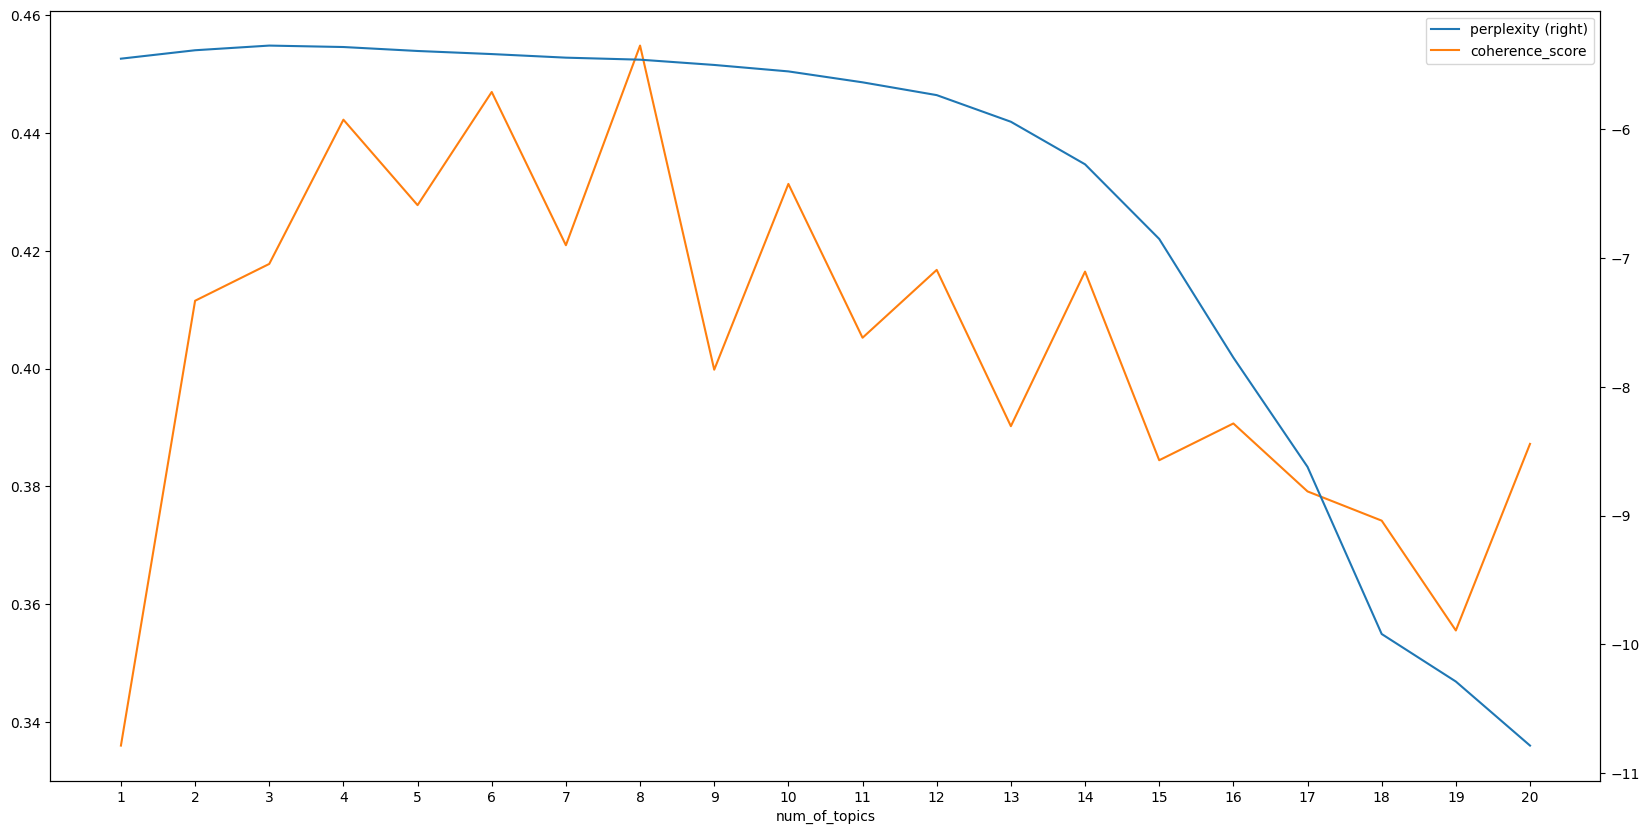

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

results.plot(secondary_y='perplexity', figsize=(20, 10))
new_ticks = np.linspace(1, 20, 20)
plt.xticks(new_ticks)
plt.show()

We can use a visualization tool *pyLDAvis* to help us understand the topics better. </br>
    
*Ref:*</br>
https://pypi.org/project/pyLDAvis/</br>
https://blog.csdn.net/qq_39496504/article/details/107125284</br>

In [28]:
#%pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, path + os.sep + '../img/lda.html')
pyLDAvis.display(vis)